In [110]:
import math
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
import torchvision.transforms.functional as TF
import torch
from pathlib import Path
from collections import Counter
from torchvision.transforms import Compose, ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness, RandomAffine

from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mip.utils import listfiles, extract_ome_tiff, R_CHANNEL_MAPPING, make_pseudo, display_region

In [6]:
out_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/classification_v3'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [46]:
fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3',
                      regex=r'.pt$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT110B1_S1H4_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT171B1-S1H9A1-4_left_05122023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT171B1-S1H9A1-4_right_05122023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_H1_06252022_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_H1_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_S1H2L4_20221028_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT243B1-S1H4A4_04192023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT243B1-S1H4A4_left_05122023_resul

In [47]:
sample_to_fp = {fp.split('/')[-1].split('_results')[0]:fp for fp in fps}

In [48]:
sample_to_tables = {}
sample_to_thumbnails = {}
for fp in fps:
    sample = fp.split('/')[-1].split('_results')[0]
    print(sample)
    
    obj = torch.load(fp)
    sample_to_tables[sample] = obj['tables']
    sample_to_thumbnails[sample] = obj['images']['thumbnail']
sample_to_tables.keys()

HT110B1_S1H4
HT171B1-S1H9A1-4_left_05122023
HT171B1-S1H9A1-4_right_05122023
HT206B1_H1_06252022
HT206B1_H1
HT206B1_S1H2L4_20221028
HT243B1-S1H4A4_04192023
HT243B1-S1H4A4_left_05122023
HT243B1-S1H4A4_right_05122023
HT243B1_S1H4
HT271B1-S1H6A5_04192023
HT271B1-S1H6A5_left_05122023
HT271B1-S1H6A5_right_05122023
HT297B1_H1_08042022
HT305B1_S1H1
HT308B1-S1H5A4_04192023
HT308B1-S1H5A4_left_05122023
HT308B1-S1H5A4_right_05122023
HT323B1_H1A1
HT323B1_H1A4
HT323B1_H1_08042022
HT323B1_H3
HT339B1_H1A1
HT339B1_H2A1
HT339B1_H4A4
HT342C1_Th1K4A1_section1_03042022
HT342C1_Th1K4A1_section2_03042022
HT347C1_Th1K2A1_section1_03042022
HT347C1_Th1K2A1_section2_03042022
HT365B1_S1H1_02132023
HT397B1_H2A2
HT397B1_H3A1
HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023
HT397B1_U2_03162023
HT413C1-K2_04262023
HT427P1_S1H1A3_20221020
HT480B1_S1H2_R001
HT480B1_S1H2_R002
HT488C1-Th1K1Fp1-U14_041823
HT488C1-Th1K1Fp1-U2_041323
HT553P1-H2_04262023
HT565B1-H2_04262023


dict_keys(['HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023', 'HT171B1-S1H9A1-4_right_05122023', 'HT206B1_H1_06252022', 'HT206B1_H1', 'HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023', 'HT243B1-S1H4A4_right_05122023', 'HT243B1_S1H4', 'HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023', 'HT271B1-S1H6A5_right_05122023', 'HT297B1_H1_08042022', 'HT305B1_S1H1', 'HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023', 'HT308B1-S1H5A4_right_05122023', 'HT323B1_H1A1', 'HT323B1_H1A4', 'HT323B1_H1_08042022', 'HT323B1_H3', 'HT339B1_H1A1', 'HT339B1_H2A1', 'HT339B1_H4A4', 'HT342C1_Th1K4A1_section1_03042022', 'HT342C1_Th1K4A1_section2_03042022', 'HT347C1_Th1K2A1_section1_03042022', 'HT347C1_Th1K2A1_section2_03042022', 'HT365B1_S1H1_02132023', 'HT397B1_H2A2', 'HT397B1_H3A1', 'HT397B1_S1H1A3U22_04122023', 'HT397B1_S1H1A3U31_04062023', 'HT397B1_U12_03172023', 'HT397B1_U2_03162023', 'HT413C1-K2_04262023', 'HT427P1_S1H1A3_20221020', 'HT480B1_S1H2_R001', 'HT480B1_

In [51]:
type_to_combined = {}
for k in next(iter(sample_to_tables.values())).keys():
    combined = None
    for s, tables in sample_to_tables.items():
        df = tables[k].copy()
        df.index = [f'{s}_{x}' for x in df.index]
        df.index.name = 'label'
        df['sample'] = s

        df = df.transpose()

        if combined is None:
            combined = df
        else:
            combined = pd.merge(combined, df, left_index=True, right_index=True, how='outer')
    combined = combined.transpose()
    combined.index.name = 'label'
    type_to_combined[k] = combined

In [52]:
type_to_combined.keys()

dict_keys(['region', 'ductal', 'myoepi', 'boundary', 'expanded'])

In [53]:
samples = sorted(sample_to_tables.keys())
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT297B1_H1_08042022',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B1_H4A4',
 'HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT413C1-K2_04262023',
 'HT427P1_S1H1A3_20221020',
 'H

In [54]:
sorted(type_to_combined['region'].columns)

['area',
 'c1',
 'c2',
 'cell_type_fraction_B cell',
 'cell_type_fraction_CD4 T cell',
 'cell_type_fraction_CD8 T cell',
 'cell_type_fraction_Endothelial',
 'cell_type_fraction_Epithelial',
 'cell_type_fraction_Immune',
 'cell_type_fraction_Macrophage - M1',
 'cell_type_fraction_Stroma',
 'cell_type_fraction_Treg',
 'cell_type_fraction_Unlabeled',
 'col',
 'compactness',
 'marker_fraction_CD11b',
 'marker_fraction_CD163',
 'marker_fraction_CD20',
 'marker_fraction_CD31',
 'marker_fraction_CD3e',
 'marker_fraction_CD4',
 'marker_fraction_CD45',
 'marker_fraction_CD68',
 'marker_fraction_CD8',
 'marker_fraction_CK14',
 'marker_fraction_CK17',
 'marker_fraction_CK5',
 'marker_fraction_E-cadherin',
 'marker_fraction_FOXP3',
 'marker_fraction_HLA-DR',
 'marker_fraction_Ki67',
 'marker_fraction_Pan-Cytokeratin',
 'marker_fraction_Podoplanin',
 'marker_fraction_SMA',
 'marker_intensity_BCA1',
 'marker_intensity_Bap1',
 'marker_intensity_CCL2-(D)',
 'marker_intensity_CD11b',
 'marker_intensity

In [55]:
ncols = 6
nrows = len(samples) // ncols + 1

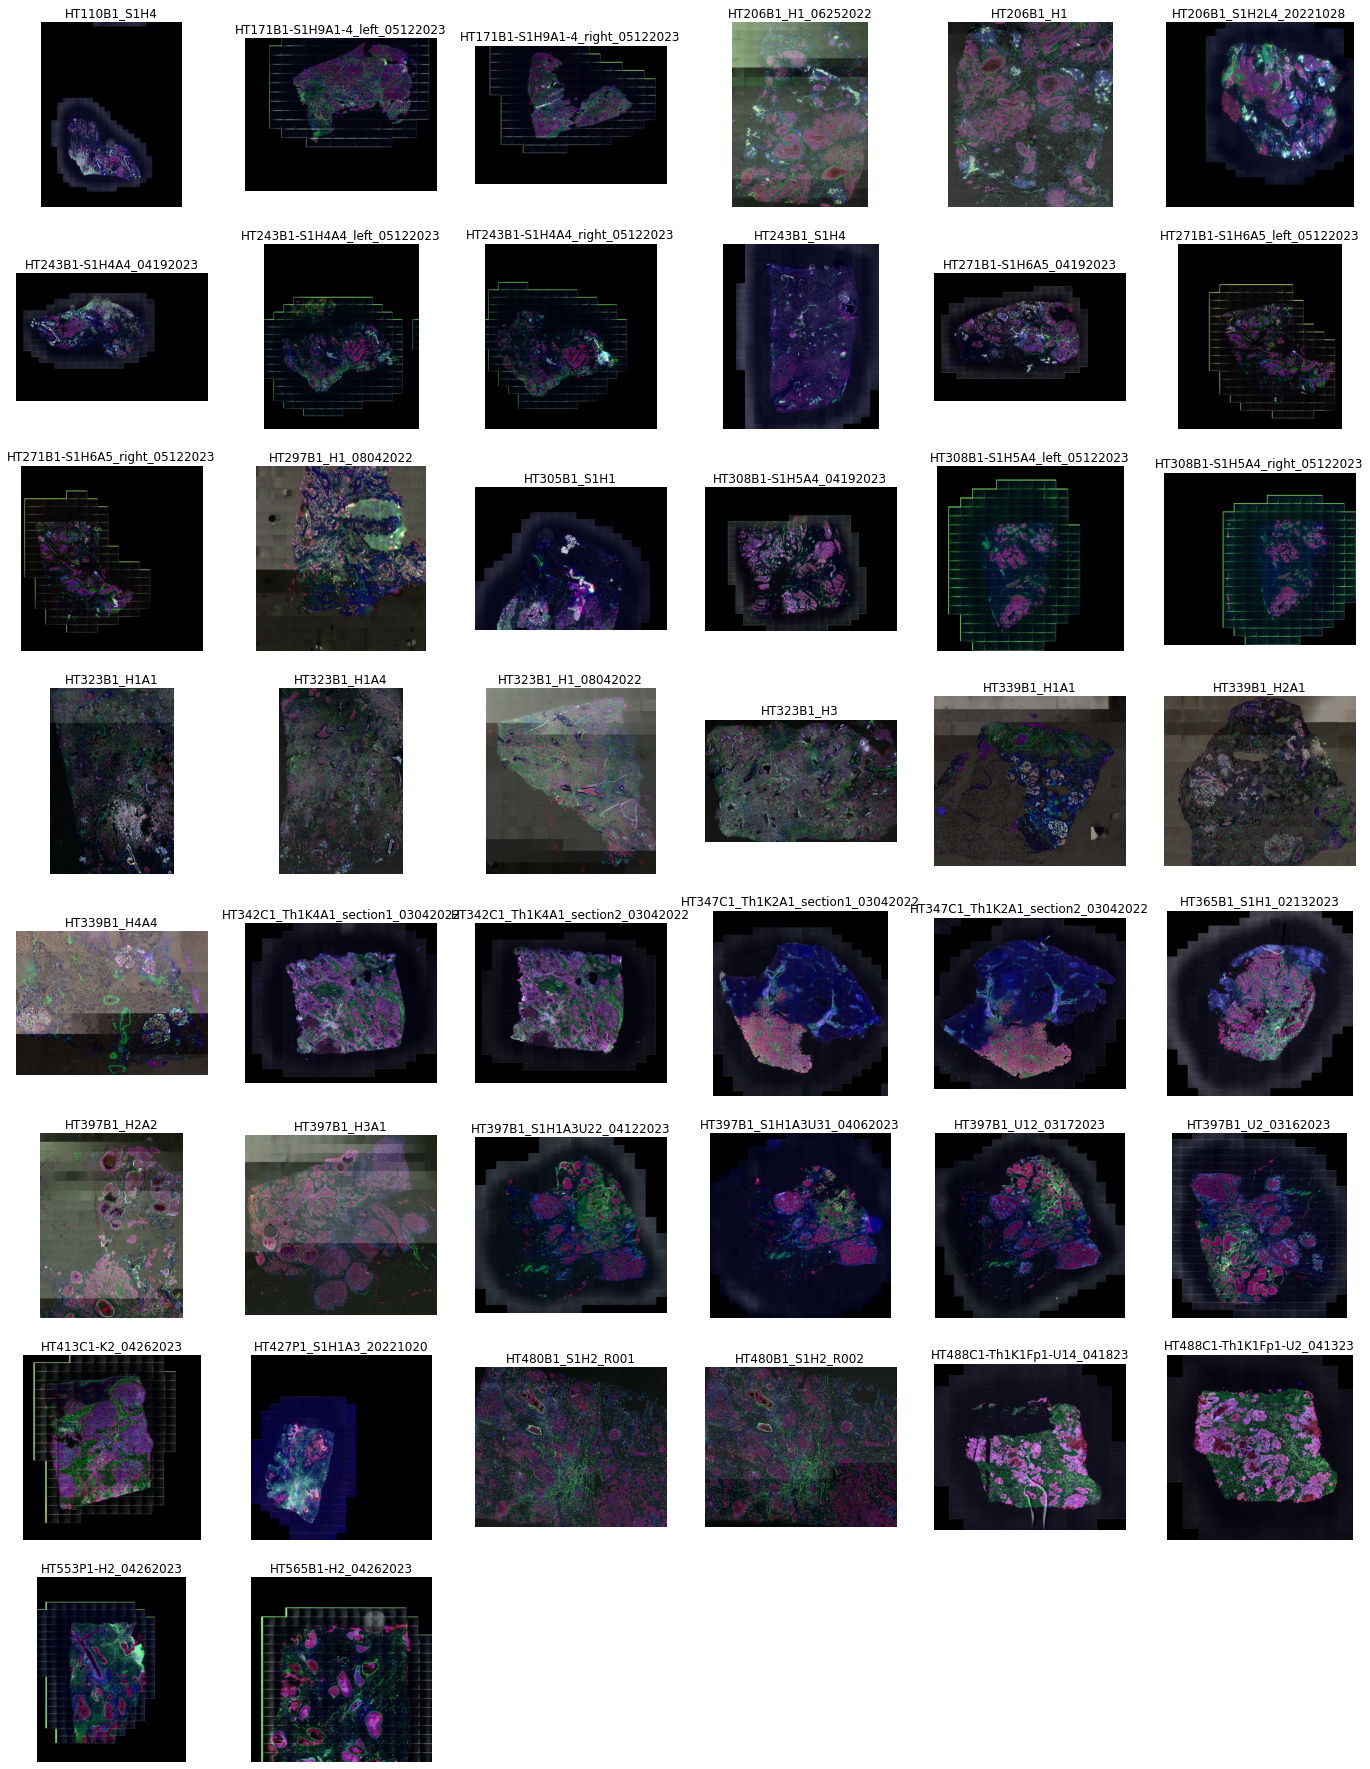

In [56]:
fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
stack = [(s, thumbnails['pseudo']) for s, thumbnails in sample_to_thumbnails.items()]
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        
        if len(stack):
            s, thumbnail = stack.pop(0)
            ax.imshow(thumbnail)
            ax.set_title(s)
        ax.axis('off')

In [57]:
scale = .1

HT565B1-H2_04262023
21


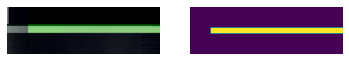

33


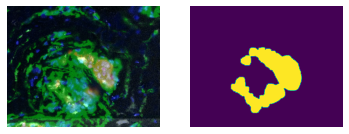

4


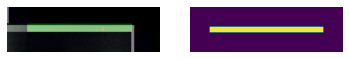

84


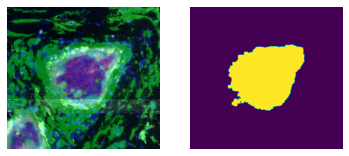

87


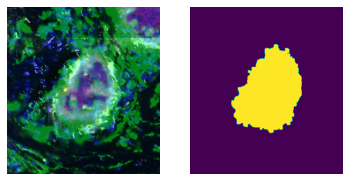

30


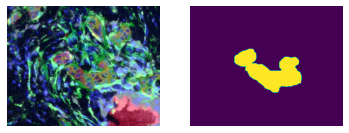

52


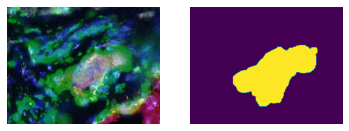

63


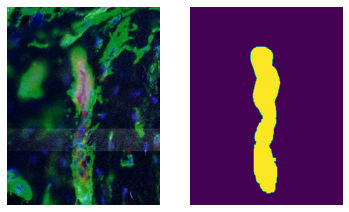

90


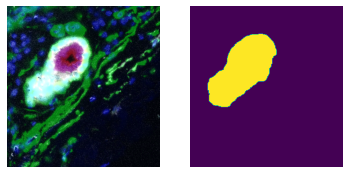

47


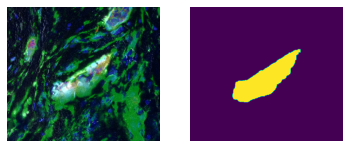

79


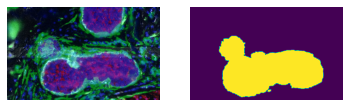

46


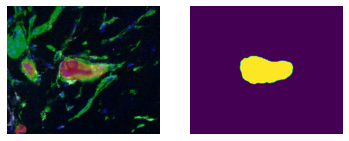

78


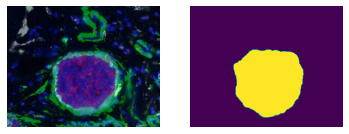

12


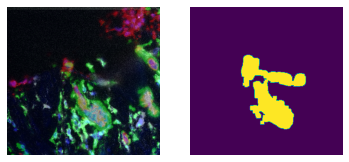

89


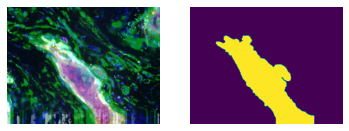

56


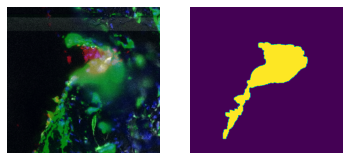

55


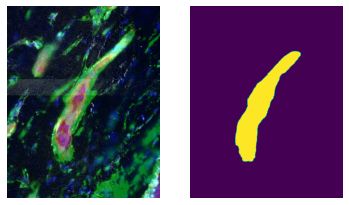

53


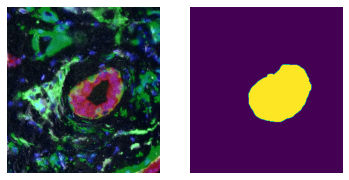

48


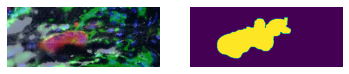

32


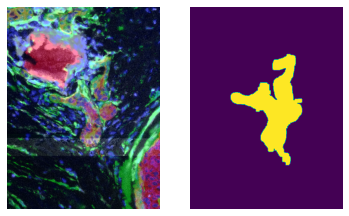

66


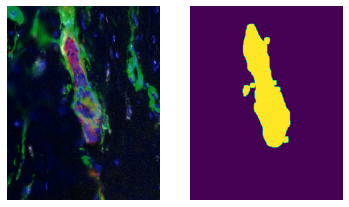

31


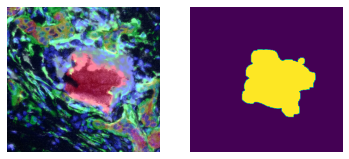

91


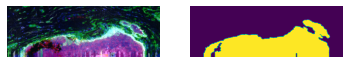

28


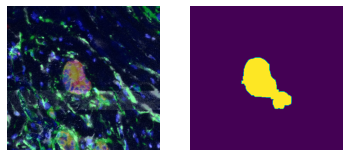

57


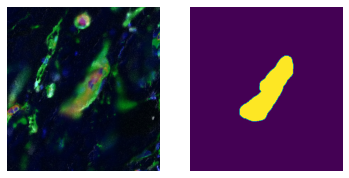

80


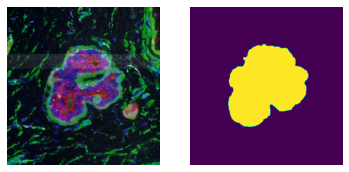

83


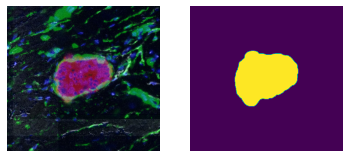

60


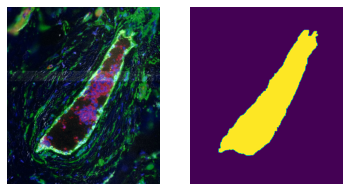

36


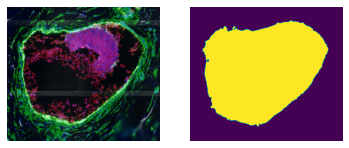

68


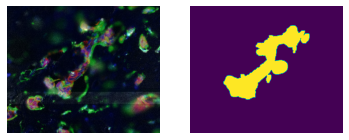

67


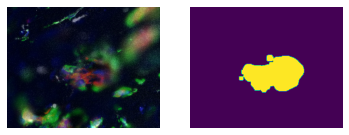

77


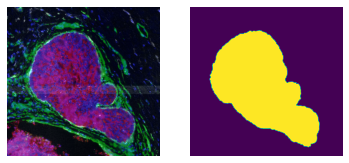

16


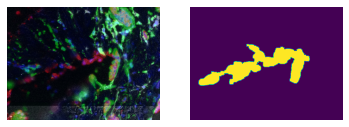

25


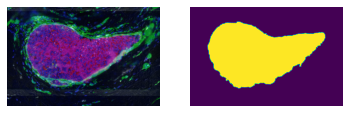

81


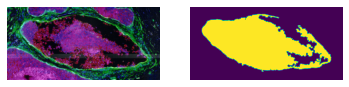

74


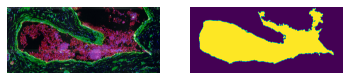

65


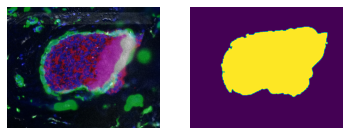

85


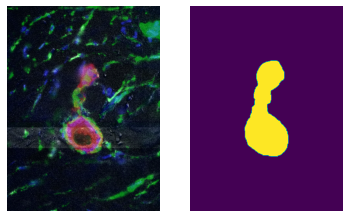

71


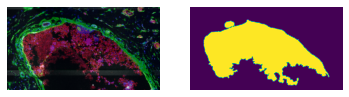

45


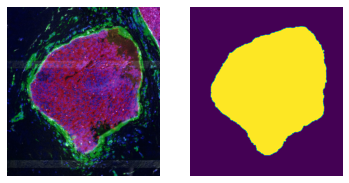

49


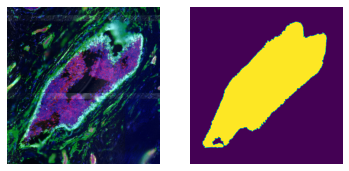

69


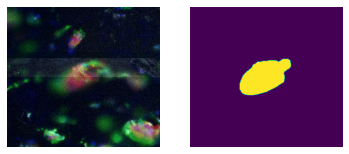

35


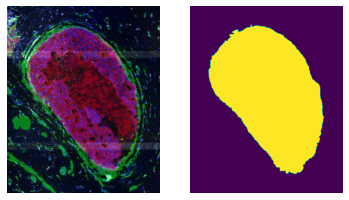

40


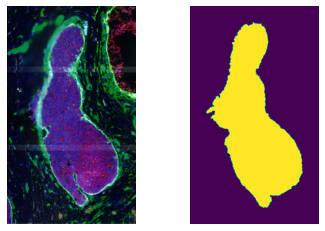

72


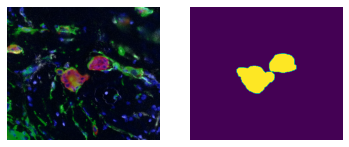

62


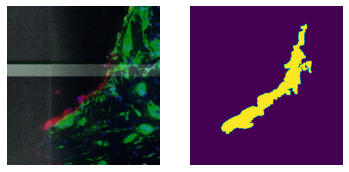

64


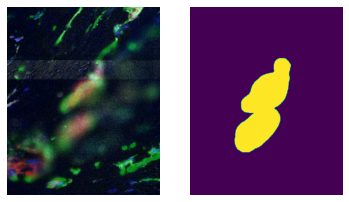

50


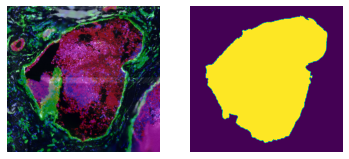

86


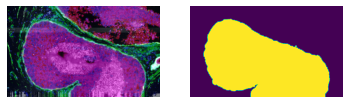

51


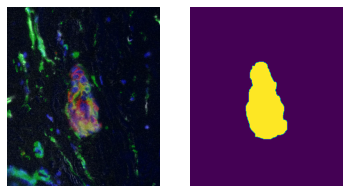

22


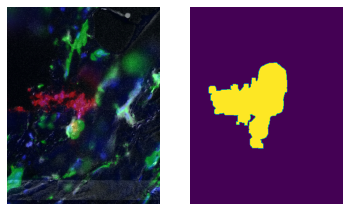

34


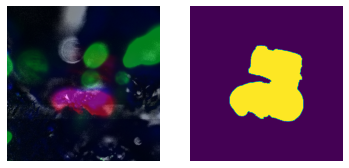

92


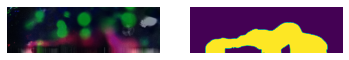

61


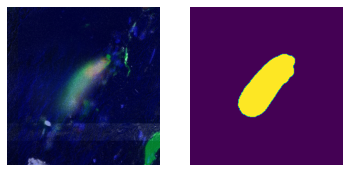

13


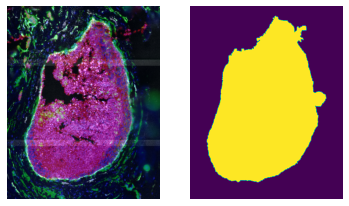

58


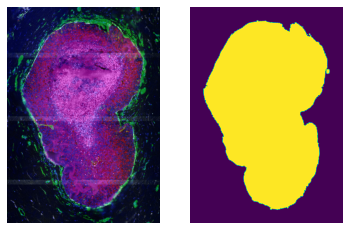

82


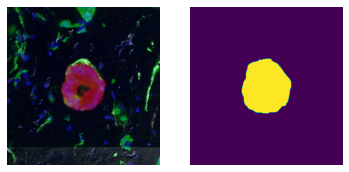

26


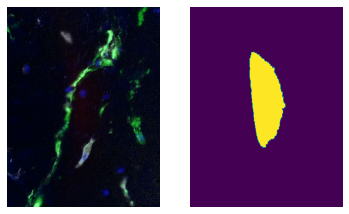

19


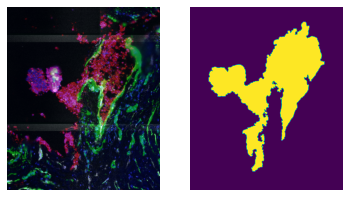

41


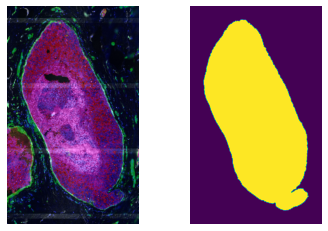

59


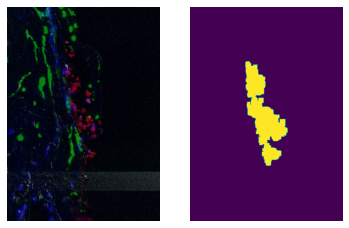

17


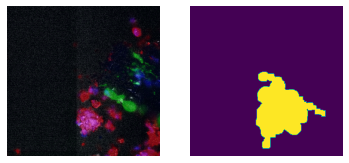

37


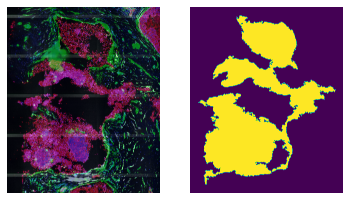

14


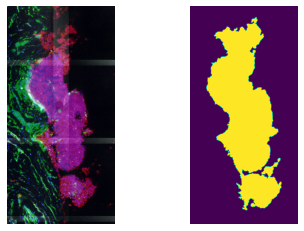

54


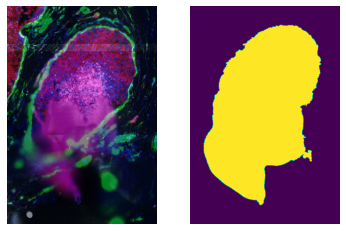

10


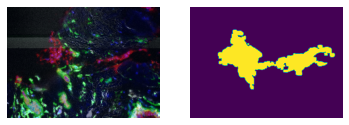

18


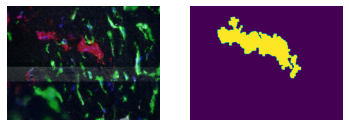

73


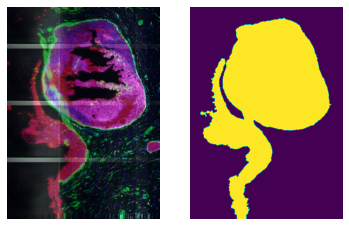

27


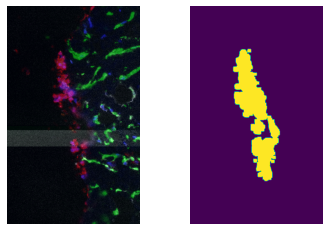

70


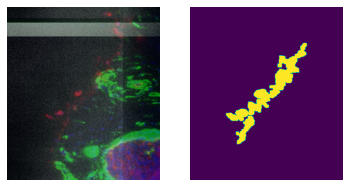

7


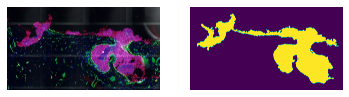

43


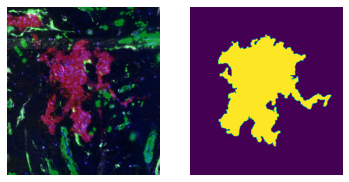

24


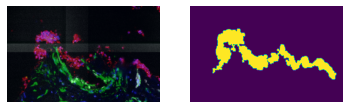

23


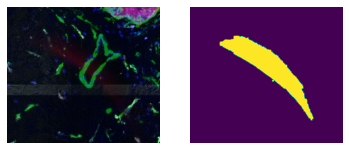

20


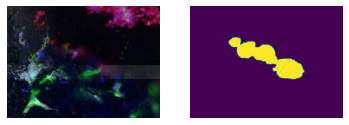

88


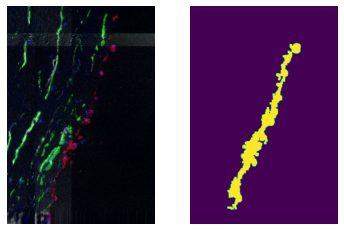

76


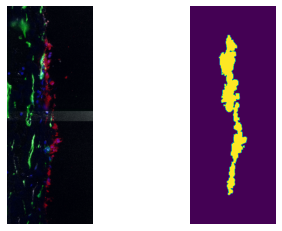

29


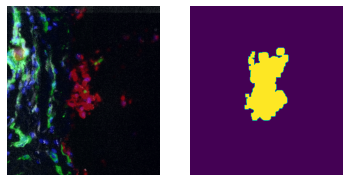

6


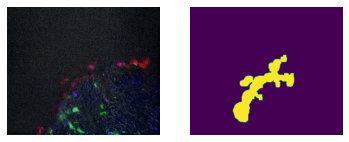

9


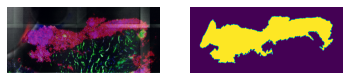

1


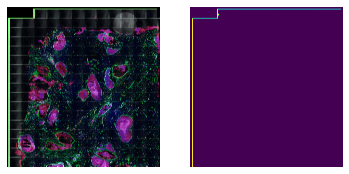

11


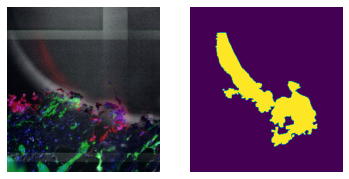

38


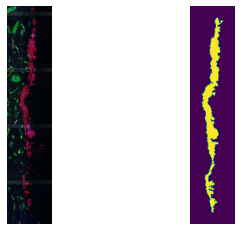

8


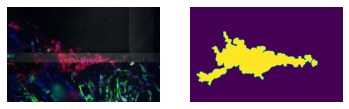

42


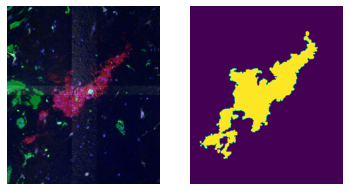

15


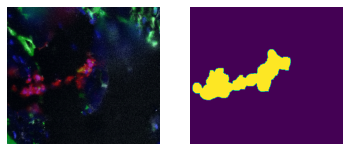

39


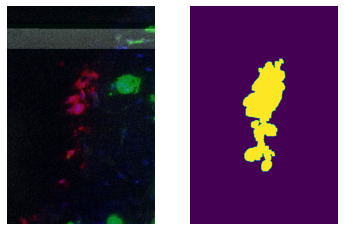

5


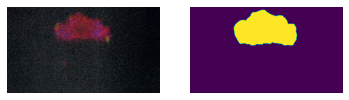

44


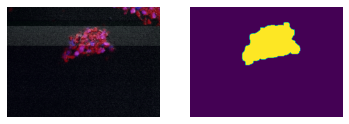

2


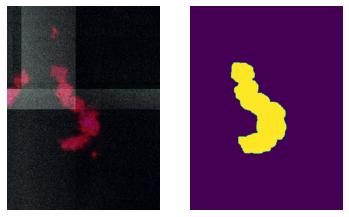

75


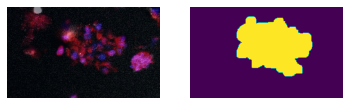

3


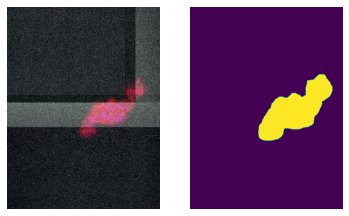

In [82]:
for sample in samples[-1:]:
    print(sample)
    df = sample_to_tables[sample]['expanded'][['r1', 'r2', 'c1', 'c2']]
    region_to_bbox = {region:(r1, r2, c1, c2) for region, (r1, r2, c1, c2) in zip(df.index, df.values)}
    
    region_table = sample_to_tables[sample]['region']
    myoepi_table = sample_to_tables[sample]['myoepi']
    
    myoepi_table = myoepi_table.sort_values('marker_fraction_SMA', ascending=False)
    
    obj = torch.load(sample_to_fp[sample])
    pseudo = obj['images']['fullres']['pseudo']
    labeled = obj['images']['fullres']['labeled']['region']
    
    for region in myoepi_table.index:
        fig, axs = plt.subplots(ncols=2)
        
        r1, r2, c1, c2 = region_to_bbox[region]
#         r1, r2, c1, c2 = [int(x * scale) for x in [r1, r2, c1, c2]]
        tile = pseudo[r1:r2, c1:c2]
        print(region)
        axs[0].imshow(tile)
        axs[0].axis('off')
        
        tile = labeled[r1:r2, c1:c2]
        mask = np.zeros_like(tile, dtype=bool)
        mask[tile==int(region)] = True
        axs[1].imshow(mask)
        axs[1].axis('off')
        
        plt.show()


In [86]:
sample_to_classifications = {
    'HT110B1_S1H4': {
        'normal': [264, 263, 117, 89, 187, 152, ],
        'dcis': [85, 220],
        'idc': [200, 235, 153, 247, 230, 255, 168, 177, 248, 240, 227, 182, 206, 243, 245, 246, 124, 159, 225],
        'artifact': [271, 270],},
    'HT171B1-S1H9A1-4_left_05122023': {
        'normal': [],
        'dcis': [],
        'idc': [95, 134, 159, 144, 156, 80, 47, 12, 166, 135, 65, 98, 79, 25, 104, 158, 59, 83, 127, 37, 2, 8, 172],
        'artifact': [72, 174, 18, 111, 20, ],},
    'HT171B1-S1H9A1-4_right_05122023': {
        'normal': [],
        'dcis': [],
        'idc': [95, 96, 70, 145, 76, 147, 157, 168, 115, 77, 155, 97, 128, 43, 39],
        'artifact': [19, 8, 29, 3, 50, 1, 170, 87, 41, ],},
    'HT206B1_H1': {
        'normal': [112, 87, 22, 129, 109, 208, 128, 202, 92, 189, 116, 201, 209, 103],
        'dcis': [101, 197, 182, 41, 42, 49, 179, 110, 178, 96, 120, 212],
        'idc': [218, 135, 108, 131, 54, 113, 136, 23, 126, 196, 224, 27, 72, 32, 70, 219, 104, 33, 190, 228, 52, 165],
        'artifact': [],},
    'HT206B1_H1_06252022': {
        'normal': [50, 87, 313, 299, 49, 162, 187, 230, 177, 174, 214, 171, 70, 209, 77, 90, 95, 10, 89],
        'dcis': [196, 91, 109, 125, 237, 57, 88, 139, 145, 75],
        'idc': [218, 255, 296, 35, 249, 186, 246, 260, 200, 97, 217, 259, 236, 216, 284, 252, 289, 124, 140],
        'artifact': [],},
    'HT206B1_S1H2L4_20221028': {
        'normal': [114, 187, 61, 79, 125, 190, 86, 106, 166],
        'dcis': [119, 113, 8, 5, 72, 49, 40, 118, 185, 30, 156, 4, 94, 90, 21, 165, 56, 54, 160, 29, 124, 177, 28, 179, 142, 169, 38, 88],
        'idc': [65, 52, 62, 115, 167, 47, 67, 122, 37, 9],
        'artifact': [],},
    'HT243B1-S1H4A4_04192023': {
        'normal': [293, 149, 152, 68, 145, 157, 271],
        'dcis': [],
        'idc': [47, 41, 32, 28, 31, 21, 8, 86, 80, 52, 156, 168, 141, 237, 202, 124, 130, 283],
        'artifact': [],},
    'HT243B1-S1H4A4_left_05122023': {
        'normal': [131, 45, 165],
        'dcis': [],
        'idc': [249, 251, 173, 220, ],
        'artifact': [35, 17, 34, 29, 256, 21],},
    'HT243B1-S1H4A4_right_05122023': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},
    'HT243B1_S1H4': {
        'normal': [211, 205, 30, 4, 169, 57, 10, 28, 61, 53],
        'dcis': [44, 58, 43, 49, 55, 46, 48, 51, ],
        'idc': [88, 213, 206, 146, 185, 173, 67, 142, 190],
        'artifact': [26],},
    'HT271B1-S1H6A5_04192023': {
        'normal': [255, 243, 40, 33, 238, 152, 108, 115],
        'dcis': [75, 41, 66, 96, 28, 10, 86, 67, 79, 224, 78, 208, 146, 54, 69, 63, 77, 181, 131, 44],
        'idc': [188, 167, 197, 199, 48, 57, 76, 141, 19, 174, 38, 192, 121, 83],
        'artifact': [182, 173, 262, 1],},
    'HT271B1-S1H6A5_left_05122023': {
        'normal': [30, 147, 80, 9, 38, 31, 32, 8, 46, 35, 63],
        'dcis': [25, 7, 24, 42, 14, 37, 27, 36, 47],
        'idc': [141, 73, 72, 106, 16, 99, 58],
        'artifact': [1, 44, 69, 3, 132, 149, 146, 2],},
    'HT271B1-S1H6A5_right_05122023': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},
    'HT297B1_H1_08042022': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': []},# exclude
    'HT305B1_S1H1': { 
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': []},# exclude
    'HT308B1-S1H5A4_04192023': {
        'normal': [75, 119],
        'dcis': [123, 94, 83, 118, 134, 85, 35],
        'idc': [21, 44, 23, 9, 74, 22, 59, 107],
        'artifact': [270, 188, 147, 41],},
    'HT308B1-S1H5A4_left_05122023': {
        'normal': [],
        'dcis': [48, 12, 55],
        'idc': [53, 9, 49, 6, 18, 67, 59, 60],
        'artifact': [1, 65, 2],},
    'HT308B1-S1H5A4_right_05122023': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},
    'HT323B1_H1A1': {
        'normal': [633, 711, 623, 621, 684, 630, 722, 522, 503, 438, 360, 397, 416, 328, 666],
        'dcis': [213, 24, 22],
        'idc': [323, 436, 232, 412, 19, 312, 173, 85, 381, 390, 317, 419],
        'artifact': [653],},
    'HT323B1_H1A4': {
        'normal': [669, 514, 378, 202, 284, 278, 239],
        'dcis': [265, 7, 71, 16, 55, 35, 79, 2, 134, 408, 188, 86, 213, 40, 70, 3, 128],
        'idc': [174, 343, 111, 432, 271, 22],
        'artifact': []},
    'HT323B1_H1_08042022': {
        'normal': [428, 291, 582, 438],
        'dcis': [307, 443, 141, 6],
        'idc': [161, 382, 289, 301, 181, 137, 366, 128, 30],
        'artifact': [],},
    'HT323B1_H3': {
        'normal': [727, 700, 448, 625, 584, 587],
        'dcis': [279, 546, 751, 282, 699, 654, 661, 199, 487, 549, 555, 462, 920, 814, 350, 208, 320, 979],
        'idc': [1119, 183, 45, 254, 653, 690, 148, 412],
        'artifact': [],},
    'HT339B1_H1A1': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},# exclude
    'HT339B1_H2A1': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},# exclude
    'HT339B1_H4A4': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},# exclude
    'HT365B1_S1H1_02132023': {
        'normal': [],
        'dcis': [159, 153],
        'idc': [158, 148, 160, 37, 6, 10],
        'artifact': [],},
    'HT397B1_H2A2': {
        'normal': [],
        'dcis': [193, 216, 176, 111, 50, 253, 9, 5, 69, 129, 48, 37, 54, 108, 55, 58, 41, 51, 6, 197, 33, 40, 142, 23, 25, 35],
        'idc': [228, 132, 227, 102, 152, 30],
        'artifact': [],},
    'HT397B1_H3A1': {
        'normal': [],
        'dcis': [122, 338, 97, 423, 392, 126, 422, 227, 455, 107, 411, 370, 157, 436, 430, 254],
        'idc': [365, 176, 255, 104, 212],
        'artifact': [],},
    'HT397B1_S1H1A3U22_04122023': {
        'normal': [],
        'dcis': [36, 17, 11, 24, 14],
        'idc': [91, 81, 77, 89, 194],
        'artifact': []},
    'HT397B1_S1H1A3U31_04062023': {
        'normal': [],
        'dcis': [53, 16, 33, 8],
        'idc': [22],
        'artifact': [],},
    'HT397B1_U12_03172023': {
        'normal': [],
        'dcis': [43, 117, 41, 79, 54, 22, 76, 35, 13, 67, 44, 17, 40, 26, 30, 11],
        'idc': [121, 33, 213, 14],
        'artifact': [],},
    'HT397B1_U2_03162023': {
        'normal': [],
        'dcis': [],
        'idc': [],
        'artifact': [],},
    'HT480B1_S1H2_R001': {
        'normal': [],
        'dcis': [176, 24, 96, 92],
        'idc': [28, 281, 309, 135, 159],
        'artifact': [],},
    'HT480B1_S1H2_R002': {
        'normal': [],
        'dcis': [92, 97, 104, 182, 27, 47, 36, 106, 88, 26],
        'idc': [237, 204],
        'artifact': [],},
    'HT565B1-H2_04262023': {
        'normal': [90, 30, ],
        'dcis': [79, 78, 91, 60, 36, 77, 25, 81, 74, 65, 71, 45, 35, 40, 50, 86, 13, 58, 41, 54],
        'idc': [85, 2],
        'artifact': [4],}
}
r_sample_to_classifications = {f'{s}_{r}':l for s, cls in sample_to_classifications.items()
                               for l, rs in cls.items()
                               for r in rs}

In [44]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness, RandomResizedCrop, RandomAffine
from einops import rearrange

In [204]:
region_to_cls_imgs = {}
for sample, classifications in sample_to_classifications.items():
    print(sample)
    df = sample_to_tables[sample]['expanded'][['r1', 'r2', 'c1', 'c2']]
    region_to_bbox = {region:(r1, r2, c1, c2) for region, (r1, r2, c1, c2) in zip(df.index, df.values)}
    
    obj = torch.load(sample_to_fp[sample])
    pseudo = obj['images']['fullres']['pseudo'].to(torch.float32)
    pseudo /= pseudo.max()
    labeled = torch.tensor(obj['images']['fullres']['labeled']['region'])
    
    for region in df.index:
        
#     for label, regions in classifications.items():
#         for region in regions:
        identifier = f'{sample}_{region}'
#         print(identifier)
        r1, r2, c1, c2 = region_to_bbox[region]
        tile_pseudo = pseudo[r1:r2, c1:c2]
        tile = labeled[r1:r2, c1:c2]
        tile_mask = torch.zeros_like(tile, dtype=bool)
        tile_mask[tile==int(region)] = True

        tile_pseudo = rearrange(tile_pseudo, 'h w c -> c h w')
        tile_mask = tile_mask.unsqueeze(dim=0)
        h, w = r2 - r1, c2 - c1
        if h > w:
            ratio = w / h
            padding = int((256 - (256 * ratio)) // 2)
            tile_pseudo = TF.resize(tile_pseudo, (256, int(256 * ratio)))
            tile_mask = TF.resize(tile_mask, (256, int(256 * ratio)))

            tile_pseudo = TF.pad(tile_pseudo, (padding, 0, padding, 0),
                                 padding_mode='reflect' if ratio > 1.0 else 'constant') # just make constant default for now
            tile_mask = TF.pad(tile_mask, (padding, 0, padding, 0),
                               padding_mode='reflect' if ratio > 1.0 else 'constant')
                
        else:
            ratio = h / w
            padding = int((256 - (256 * ratio)) // 2)
            tile_pseudo = TF.resize(tile_pseudo, (int(256 * ratio), 256))
            tile_mask = TF.resize(tile_mask, (int(256 * ratio), 256))
            tile_pseudo = TF.pad(tile_pseudo, (0, padding, 0, padding),
                                padding_mode='reflect' if ratio > 1.0 else 'constant')
            tile_mask = TF.pad(tile_mask, (0, padding, 0, padding),
                              padding_mode='reflect' if ratio > 1.0 else 'constant')


        tile_pseudo = TF.resize(tile_pseudo, (256, 256))
        tile_mask = TF.resize(tile_mask, (256, 256))

        region_to_cls_imgs[identifier] = {
            'rgb': tile_pseudo,
            'mask': tile_mask,
            'label': r_sample_to_classifications.get(identifier, 'unknown')
        }

HT110B1_S1H4
HT171B1-S1H9A1-4_left_05122023
HT171B1-S1H9A1-4_right_05122023
HT206B1_H1
HT206B1_H1_06252022
HT206B1_S1H2L4_20221028
HT243B1-S1H4A4_04192023
HT243B1-S1H4A4_left_05122023
HT243B1-S1H4A4_right_05122023
HT243B1_S1H4
HT271B1-S1H6A5_04192023
HT271B1-S1H6A5_left_05122023
HT271B1-S1H6A5_right_05122023
HT297B1_H1_08042022
HT305B1_S1H1
HT308B1-S1H5A4_04192023
HT308B1-S1H5A4_left_05122023
HT308B1-S1H5A4_right_05122023
HT323B1_H1A1
HT323B1_H1A4
HT323B1_H1_08042022
HT323B1_H3
HT339B1_H1A1
HT339B1_H2A1
HT339B1_H4A4
HT365B1_S1H1_02132023
HT397B1_H2A2
HT397B1_H3A1
HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023
HT397B1_U2_03162023
HT480B1_S1H2_R001
HT480B1_S1H2_R002
HT565B1-H2_04262023


In [ ]:
tups = sorted([(d['label'], k) for k, d in region_to_cls_imgs.items()], key=lambda x: x[0])
for _, k in tups:
    d = region_to_cls_imgs[k]
    if d['label'] != 'unknown':
        print(k, d['label'])
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(rearrange(d['rgb'], 'c h w -> h w c'))
        axs[1].imshow(d['mask'][0])
        plt.show()

In [206]:
to_remove = [
    'HT110B1_S1H4_270',
    'HT110B1_S1H4_271',
    'HT171B1-S1H9A1-4_left_05122023_18',
    'HT171B1-S1H9A1-4_left_05122023_20',
    'HT171B1-S1H9A1-4_left_05122023_111',
    'HT171B1-S1H9A1-4_right_05122023_41',
    'HT171B1-S1H9A1-4_right_05122023_87',
    'HT243B1_S1H4_26',
    'HT271B1-S1H6A5_04192023_1',
    'HT271B1-S1H6A5_04192023_173',
    'HT271B1-S1H6A5_04192023_182',
    'HT323B1_H1A1_653',
    'HT271B1-S1H6A5_04192023_63',
    'HT271B1-S1H6A5_04192023_54',
    'HT271B1-S1H6A5_04192023_79',
    'HT271B1-S1H6A5_04192023_86',
    'HT271B1-S1H6A5_04192023_146',
    'HT271B1-S1H6A5_04192023_181',
    'HT397B1_U12_03172023_43',
    'HT397B1_U12_03172023_79',
    'HT397B1_U12_03172023_117'
]

In [207]:
img = torch.concat([d['rgb'].unsqueeze(0) for d in region_to_cls_imgs.values()])
img.mean(dim=(0, 2, 3)), img.std(dim=(0, 2, 3))

(tensor([0.1761, 0.1743, 0.2220]), tensor([0.2121, 0.2078, 0.2277]))

In [208]:
class RegionImgTransform(object):
    def __init__(self, p=.8, brightness=.2, contrast=.2, saturation=.2, hue=.2,
                 normalize=True):
        
        self.affine_transforms = Compose([
            RandomAffine(180),
            RandomResizedCrop((256, 256), scale=(.6, 1.)),
        ])
        
        self.color_transforms = Compose([
            ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        ])
        
        if normalize:
#             self.normalize = Normalize((0.219, 0.223, 0.250), (0.223, 0.227, 0.251))
#             self.normalize = Normalize((0.138, 0.087, 0.143, 0.116, 0.261), (0.260, 0.227, 0.239, 0.230, 0.276))
            self.normalize = Normalize((0.2126, 0.2129, 0.2696), (0.2147, 0.2118, 0.2238))
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def __call__(self, he, mask):
        """
        """
        if torch.rand(size=(1,)) < self.p:
            he = self.color_transforms(he)
            
            combined = torch.concat((he, mask))
            combined = self.affine_transforms(combined)
            
            he, mask = combined[:-1], combined[-1:]
            
        he = self.normalize(he)
        
        return he, mask

In [209]:
class RegionDataset(Dataset):
    def __init__(self, region_to_cls_imgs, transform=None):
        self.region_to_cls_imgs = region_to_cls_imgs
        self.transform = transform
        self.keys = sorted(self.region_to_cls_imgs.keys())
        
        self.labels = sorted(set([d['label'] for reg, d in region_to_cls_imgs.items()]))
        self.y = [self.labels.index(self.region_to_cls_imgs[k]['label']) for k in self.keys]
        self.y = torch.nn.functional.one_hot(torch.tensor(
            self.y)).to(torch.float32)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        region_id = self.keys[idx]

        rgb = self.region_to_cls_imgs[region_id]['rgb']
        mask = self.region_to_cls_imgs[region_id]['mask']
        mask = mask.to(torch.float32)

        if self.transform:
            rgb, mask = self.transform(rgb, mask)

        return {
            'mask': mask,
            'rgb': rgb,
            'y': self.y[idx],
        }

In [210]:
Counter(d['label'] for d in region_to_cls_imgs.values()).most_common()

[('unknown', 9292),
 ('idc', 247),
 ('dcis', 244),
 ('normal', 123),
 ('artifact', 44)]

In [211]:
labeled_keys = [k for k, v in region_to_cls_imgs.items() if v['label']!='unknown' if k not in to_remove]
partition = np.random.permutation(labeled_keys)
cut = int(len(partition) * .8)
train_keys = partition[:cut]
val_keys = partition[cut:]
len(train_keys), len(val_keys)

(509, 128)

In [212]:
train_region_to_cls_imgs = {k:v for k, v in region_to_cls_imgs.items() if k in train_keys}
val_region_to_cls_imgs = {k:v for k, v in region_to_cls_imgs.items() if k in val_keys}

In [213]:
train_ds = RegionDataset(train_region_to_cls_imgs, transform=RegionImgTransform(p=.8))
val_ds = RegionDataset(val_region_to_cls_imgs, transform=RegionImgTransform(p=0.))
pred_ds = RegionDataset(region_to_cls_imgs, transform=RegionImgTransform(p=0.))

In [214]:
d = train_ds[2]

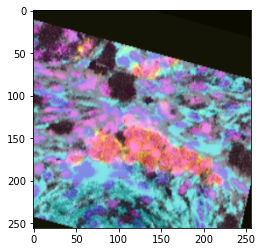

In [215]:
img = rearrange(d['rgb'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

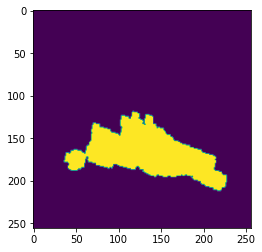

In [216]:
plt.imshow(d['mask'][0])

In [217]:
d['y']

tensor([0., 0., 1., 0.])

In [218]:
d = val_ds[0]

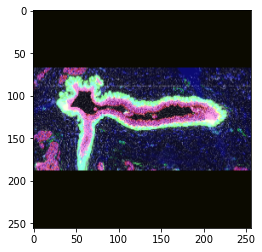

In [219]:
img = rearrange(d['rgb'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

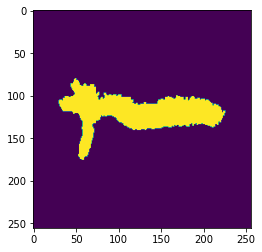

In [220]:
plt.imshow(d['mask'][0])

In [222]:
directory = os.path.join(out_dir, 'datasets')
Path(directory).mkdir(parents=True, exist_ok=True)

torch.save(train_ds, os.path.join(directory, 'train.pt'))
torch.save(val_ds, os.path.join(directory, 'val.pt'))
torch.save(pred_ds, os.path.join(directory, 'prediction.pt'))